In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from eulers_method import euler_method
from gillespie import simulate

In [3]:
def dy_dx(y):
    return -2 * pow(y, 2)
t_euler, y_euler = euler_method(dy_dx, 0.001, 0, 100, 10000)

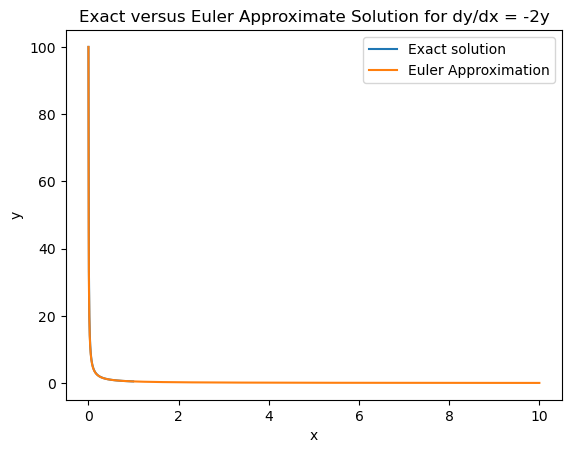

In [4]:
def exact_solution(t):
    return 100/(1 + 200*t)

t = np.arange(0, 1, 0.01)
plt.figure()
plt.plot(t, exact_solution(t), label="Exact solution")
plt.plot(t_euler, y_euler, label="Euler Approximation")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Exact versus Euler Approximate Solution for dy/dx = -2y")
plt.savefig("../../data/euler_approx.png")
plt.show()

In [2]:
def reaction_kinetics(s, t, a, b):
    x = s[0]
    y = s[1]
    dy = b * x - (y * (x**2))
    dx = a + (y * (x**2)) - b*x - x
    return dx, dy

In [3]:
tout = np.linspace(0, 10, 100)
s0 = [5, 1]  # initial state vector s
params = 1.5, 4  # A = 1.5, B = 4
s_t = odeint(reaction_kinetics, s0, tout, params)

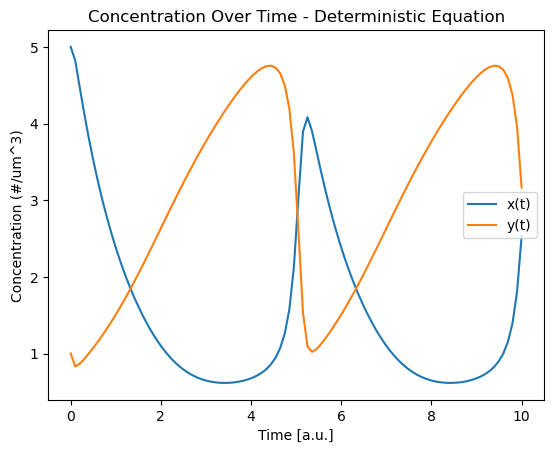

In [4]:
plt.figure()
plt.plot(tout, s_t)
plt.legend(['x(t)', 'y(t)'])
plt.xlabel("Time [a.u.]")
plt.ylabel("Concentration (#/um^3)")
plt.title("Concentration Over Time - Deterministic Equation")
plt.savefig("../../data/reaction_kinetics.png")

In [30]:
initials = [10, 2]
h = [lambda x,y: 1.5, lambda x,y: (x*(x-1)*y)/4, lambda x,y: (4*x)/2, lambda x,y:x]
stoichiometry  = [[1, 0],
                  [1, -1],
                  [-1,1],
                  [-1,0]]

In [31]:
times, measurements = simulate(initials, propensities=h, stoichiometry=stoichiometry, duration=15)
X, Y = zip(*measurements)

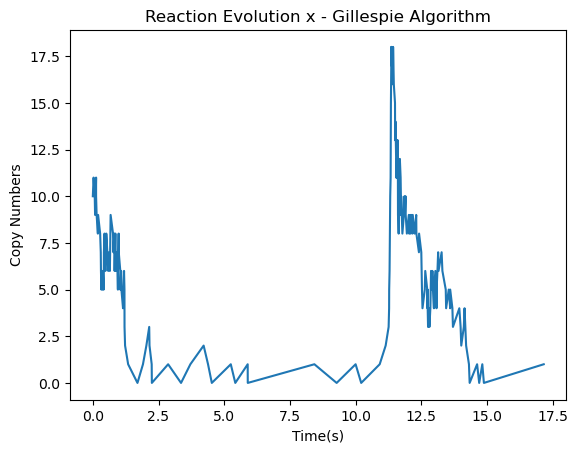

In [32]:
plt.figure()
plt.xlabel("Time(s)")
plt.ylabel("Copy Numbers")
plt.title("Reaction Evolution x - Gillespie Algorithm")
plt.plot(times, X)
plt.savefig("../../data/gillespie_x.png")

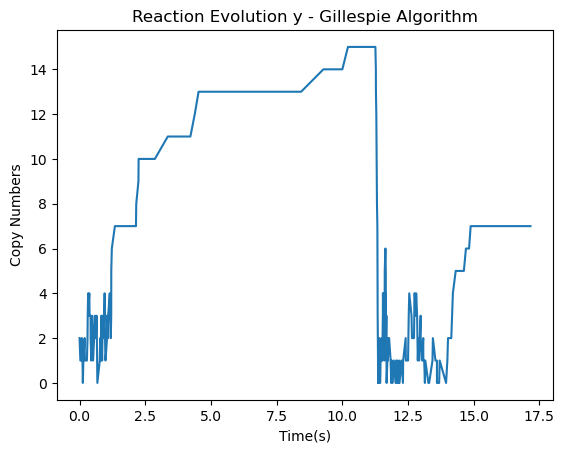

In [33]:
plt.figure()
plt.xlabel("Time(s)")
plt.ylabel("Copy Numbers")
plt.title("Reaction Evolution y - Gillespie Algorithm")
plt.plot(times, Y)
plt.savefig("../../data/gillespie_y.png")

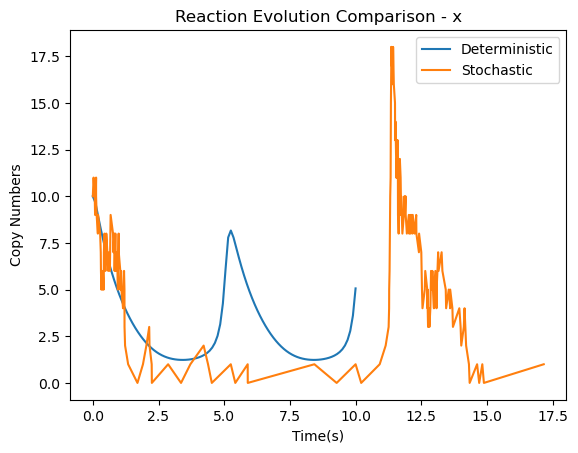

In [34]:
s_t = np.array(s_t)
s_t_cn = s_t*2

plt.figure()
plt.plot(tout, s_t_cn[:,0], label="Deterministic")
plt.plot(times, X, label="Stochastic")
plt.legend()
plt.xlabel("Time(s)")
plt.ylabel("Copy Numbers")
plt.title("Reaction Evolution Comparison - x")
plt.savefig("../../data/gillespie_compare_x.png")

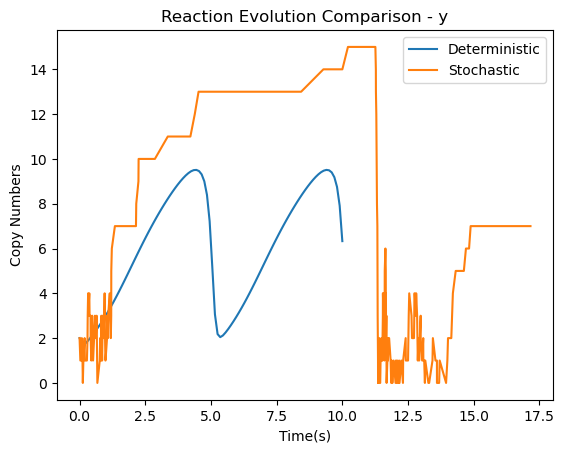

In [35]:
s_t = np.array(s_t)
s_t_cn = s_t*2
plt.figure()
plt.plot(tout, s_t_cn[:,1], label="Deterministic")
plt.plot(times, Y, label="Stochastic")
plt.legend()
plt.xlabel("Time(s)")
plt.ylabel("Copy Numbers")
plt.title("Reaction Evolution Comparison - y")
plt.savefig("../../data/gillespie_compare_y.png")

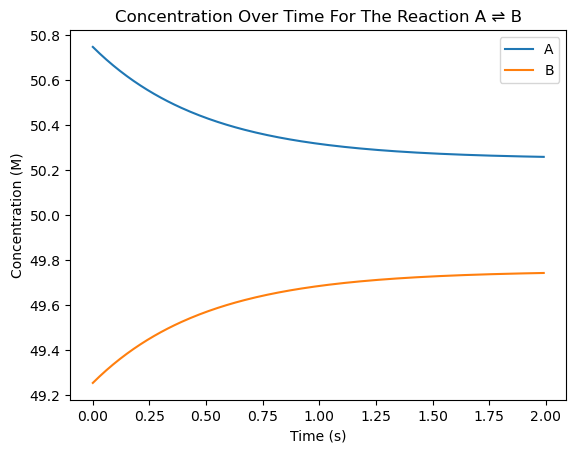

In [23]:
k_1 = 1
k_2 = 1.01
c_0 = 100

def c_a(t):
    return (np.exp(-t * (k_1 +k_2))+k_2*c_0)/(k_1+k_2)
def c_b(t):
    return c_0 - (np.exp(-t * (k_1 +k_2))+k_2*c_0)/(k_1+k_2)

plt.figure()
t = np.arange(0, 2, 0.01)
plt.plot(t, c_a(t), label="A")
plt.plot(t, c_b(t), label="B")
plt.xlabel("Time (s)")
plt.ylabel("Concentration (M)")
plt.legend()
plt.title("Concentration Over Time For The Reaction A ⇌ B")
plt.plot()
plt.savefig("../../data/reversible_reaction.png")

Ratio of open to closed 2.0 to one


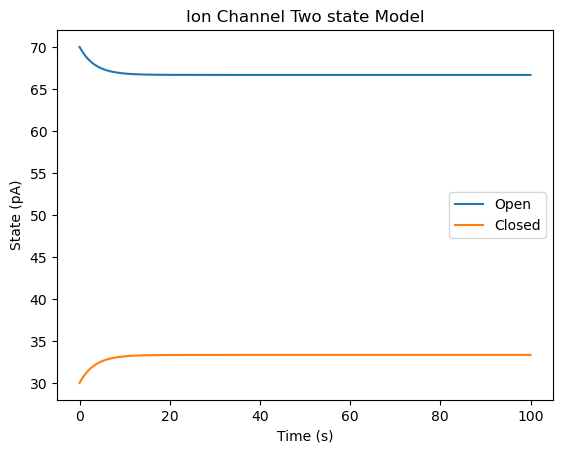

In [24]:
k_1 = 1/10
k_2 = 1/5
c_0 = 100

def c_a(t):
    return (np.exp(-t * (k_1 +k_2))+k_2*c_0)/(k_1+k_2)
def c_b(t):
    return c_0 - (np.exp(-t * (k_1 +k_2))+k_2*c_0)/(k_1+k_2)

plt.figure()
t = np.arange(0, 100, 0.01)
plt.plot(t, c_a(t), label="Open")
plt.plot(t, c_b(t), label="Closed")
plt.xlabel("Time (s)")
plt.ylabel("State (pA)")
plt.legend()
plt.title("Ion Channel Two state Model")
plt.plot()
plt.savefig("../../data/ion_channel_two_state.png")
print("Ratio of open to closed", k_2/k_1, "to one")